# Core Features: Lines and Planes in Parameter Space

This example shows the `loss-landscapes` application on scientific data segmentation, i.e. evaluating a model's loss function along lines or planes in parameter space in order to produce visualizations of the loss landscape.

In [5]:
# libraries
import copy
import sys
import time
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import h5py

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from tqdm import tqdm

matplotlib.rcParams['figure.figsize'] = [18, 12]

# code from this library - import the lines module
import loss_landscapes
import loss_landscapes.metrics

/global/homes/g/geshi/.conda/envs/CRF_GPU_Env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
sys.path.append("/global/u2/g/geshi/Scientific_Segmentation/src")
sys.path.append("/global/homes/g/geshi/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/cv2")
from models import SegmentationNet
from data_utils.input_pipeline import FiberSegDataset
from converter import print_model_h5_wegiths, inspect_pytorch_model, load_h5_params

Error in loading augmentation, can't import imgaug.Please make sure it is installed.


## 1. Preliminary: Convert keras Unet to pytorch model

Since the pretrained Unet model is in keras, here we convert it into pytorch

In [7]:
# model architecture hyperparameters
downward_params = {
    'in_channels': 3, 
    'emb_sizes': [64, 128, 256, 512], 
    'kernel_sizes': [3, 3, 3 ,3 ,3], 
    'paddings': [1, 1, 1, 1, 1], 
    'batch_norm_first': False,
}
upward_params = {
    'in_channels': [512, 1536, 768, 384, 192],
    'emb_sizes': [1024, 512, 256, 128, 64], 
    'out_channels': [1024, 512, 256, 128, 64],
    'kernel_sizes': [3, 3, 3, 3, 3], 
    'paddings': [1, 1, 1, 1, 1], 
    'batch_norm_first': False, 
    'bilinear': True,
}
output_params = {
    'in_channels': 64,
    'n_classes': 2,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
x = torch.rand(1, 3, 288, 288)
model = SegmentationNet(downward_params, upward_params, output_params)
out = model(x)
print('output shape', out.shape)

output shape torch.Size([1, 2, 288, 288])


In [9]:
model = model.to(device)
model.eval()
# stores the initial point in parameter space
model_initial = copy.deepcopy(model)

In [10]:
keras_weights_file = '/global/cfs/projectdirs/m636/Vis4ML/Fiber/unet_quarter_intern/non_crf/unet_crf_non_crf_quarter_fiber.h5'
model_param_dict = inspect_pytorch_model(model, verbose=False)

In [11]:
# gamma and beta correspond to weight and bias, respectively.
keras2torch_layers= {
    'conv2d':'encoder.blocks.0.conv_proj.conv_proj.0',
    'conv2d_1':'encoder.blocks.0.conv_proj.conv_proj.3',
    'conv2d_2':'encoder.blocks.1.conv_proj.conv_proj.0',
    'conv2d_3':'encoder.blocks.1.conv_proj.conv_proj.3',
    'conv2d_4':'encoder.blocks.2.conv_proj.conv_proj.0',
    'conv2d_5':'encoder.blocks.2.conv_proj.conv_proj.3',
    'conv2d_6':'encoder.blocks.3.conv_proj.conv_proj.0',
    'conv2d_7':'encoder.blocks.3.conv_proj.conv_proj.3',
    'conv2d_8':'decoder.blocks.0.conv_proj.conv_proj.0',
    'conv2d_9':'decoder.blocks.0.conv_proj.conv_proj.3',
    'conv2d_10':'decoder.blocks.1.conv_proj.conv_proj.0',
    'conv2d_11':'decoder.blocks.1.conv_proj.conv_proj.3',
    'conv2d_12':'decoder.blocks.2.conv_proj.conv_proj.0',
    'conv2d_13':'decoder.blocks.2.conv_proj.conv_proj.3',
    'conv2d_14':'decoder.blocks.3.conv_proj.conv_proj.0',
    'conv2d_15':'decoder.blocks.3.conv_proj.conv_proj.3',
    'conv2d_16':'decoder.conv_proj.conv_proj.0',
    'conv2d_17':'decoder.conv_proj.conv_proj.3',
    'conv2d_18':'classifier.classifier',
    'batch_normalization':'encoder.blocks.0.conv_proj.conv_proj.2',
    'batch_normalization_1':'encoder.blocks.0.conv_proj.conv_proj.5',
    'batch_normalization_2':'encoder.blocks.1.conv_proj.conv_proj.2',
    'batch_normalization_3':'encoder.blocks.1.conv_proj.conv_proj.5',
    'batch_normalization_4':'encoder.blocks.2.conv_proj.conv_proj.2',
    'batch_normalization_5':'encoder.blocks.2.conv_proj.conv_proj.5',
    'batch_normalization_6':'encoder.blocks.3.conv_proj.conv_proj.2',
    'batch_normalization_7':'encoder.blocks.3.conv_proj.conv_proj.5',
    'batch_normalization_8':'decoder.blocks.0.conv_proj.conv_proj.2',
    'batch_normalization_9':'decoder.blocks.0.conv_proj.conv_proj.5',
    'batch_normalization_10':'decoder.blocks.1.conv_proj.conv_proj.2',
    'batch_normalization_11':'decoder.blocks.1.conv_proj.conv_proj.5',
    'batch_normalization_12':'decoder.blocks.2.conv_proj.conv_proj.2',
    'batch_normalization_13':'decoder.blocks.2.conv_proj.conv_proj.5',
    'batch_normalization_14':'decoder.blocks.3.conv_proj.conv_proj.2',
    'batch_normalization_15':'decoder.blocks.3.conv_proj.conv_proj.5',
    'batch_normalization_16':'decoder.conv_proj.conv_proj.2',
    'batch_normalization_17':'decoder.conv_proj.conv_proj.5',
}
keras2torch_params = {
    'gamma:0':'weight',
    'beta:0': 'bias',
    'kernel:0': 'weight',
    'bias:0': 'bias',
    'moving_mean:0': 'running_mean',
    'moving_variance:0': 'running_var',
}

In [12]:
# load the final pretrained model
load_h5_params(keras_weights_file, model_param_dict, keras2torch_layers, keras2torch_params, verbose=False) 

In [13]:
# Hyper-parameters
val_images = "/global/cfs/projectdirs/m636/Vis4ML/Fiber/Quarter/val/img/"
val_annotations = "/global/cfs/projectdirs/m636/Vis4ML/Fiber/Quarter/val/ann/"
batch_size=64
classes = ('background', 'foreground')
n_classes = len(classes)
n_workers = 0
input_height = 288
input_width = 288
output_height = 288
output_width = 288
other_inputs_paths=None
preprocessing=None
read_image_type=1
STEPS = 20

In [14]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    ])

target_transform = transforms.Compose([
    transforms.ToTensor(),
    ])

In [15]:
dataset = FiberSegDataset(val_images, val_annotations, n_classes, 
    input_height, input_width, output_height, output_width,
    transform=data_transform, target_transform = target_transform,
    other_inputs_paths=other_inputs_paths, preprocessing=preprocessing, 
    read_image_type=read_image_type, ignore_segs=False)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers)

In [18]:
criterion = nn.CrossEntropyLoss(reduction='mean')
model_final = copy.deepcopy(model)

## 2. Loss landscape evaluation function

In [19]:
def eval_warm_up(losslandscaper, data_loader, device, criterion):
    with torch.no_grad():
        for count, batch in enumerate(data_loader, 0):
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            
            metric = loss_landscapes.metrics.Loss(criterion, x, y)
            losslandscaper.warm_up(metric)

In [20]:
def eval_loss(losslandscaper, data_loader, device, criterion):
    count = 0
    loss_data = 0.
    with torch.no_grad():
        for count, batch in enumerate(data_loader, 0):
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            batch_size = x.shape[0]
            
            metric = loss_landscapes.metrics.Loss(criterion, x, y)
            batch_loss_data = losslandscaper.compute(metric)
            
            loss_data = count/(count+batch_size)*loss_data + batch_size/(count+batch_size)*batch_loss_data
            count+=batch_size
    return loss_data

In [21]:
x, y = iter(dataloader).__next__()
metric = loss_landscapes.metrics.Loss(criterion, x.to(device), y.to(device))

## 3. Linear Interpolations of Loss between Two Points

In the previous section, copies of the model before and after training were obtained. A common use case is to evaluate the model loss at a number of equidistant points along the straight line connecting the two points. Although care must be taken in interpreting such plots, the idea is to gain an insight into the smoothness of the landscape.

The user might also be interested in collecting any other quantity along this line. The `loss-landscapes` library abstracts these details with entities called `Metric`s, which compute some quantity about a model for its current parameters. A number of pre-defined metrics is provided in the `loss_landscapes.metrics` package, and the user is free to write custom metrics. See the relevant documentation.

An important metric is `Loss`, which applies a PyTorch loss function to a PyTorch model and returns the value produced. 

In [22]:
lll = loss_landscapes.LinearLossLandscape(model_final, STEPS, deepcopy_model=True)
lll.interpolation(model_initial)
# Uncomment the following line if you draw linear random line
# lll.random_line(distance=10, normalization='filter', random='normal')
lll.stats_initializer()

In [27]:
# single batch computation
since = time.time()
# lll.warm_up(metric)
loss_data = lll.compute(metric)
print('time elapsed, ', time.time()-since)

time elapsed,  3.759075880050659


In [ ]:
eval_warm_up(lll, dataloader, device, criterion)

In [25]:
since = time.time()
loss_data = eval_loss(lll, dataloader, device, criterion)
print('time elapsed, ', time.time()-since)

time elapsed,  220.47201299667358


With the computed loss data, a linear interpolation plot can be rendered.

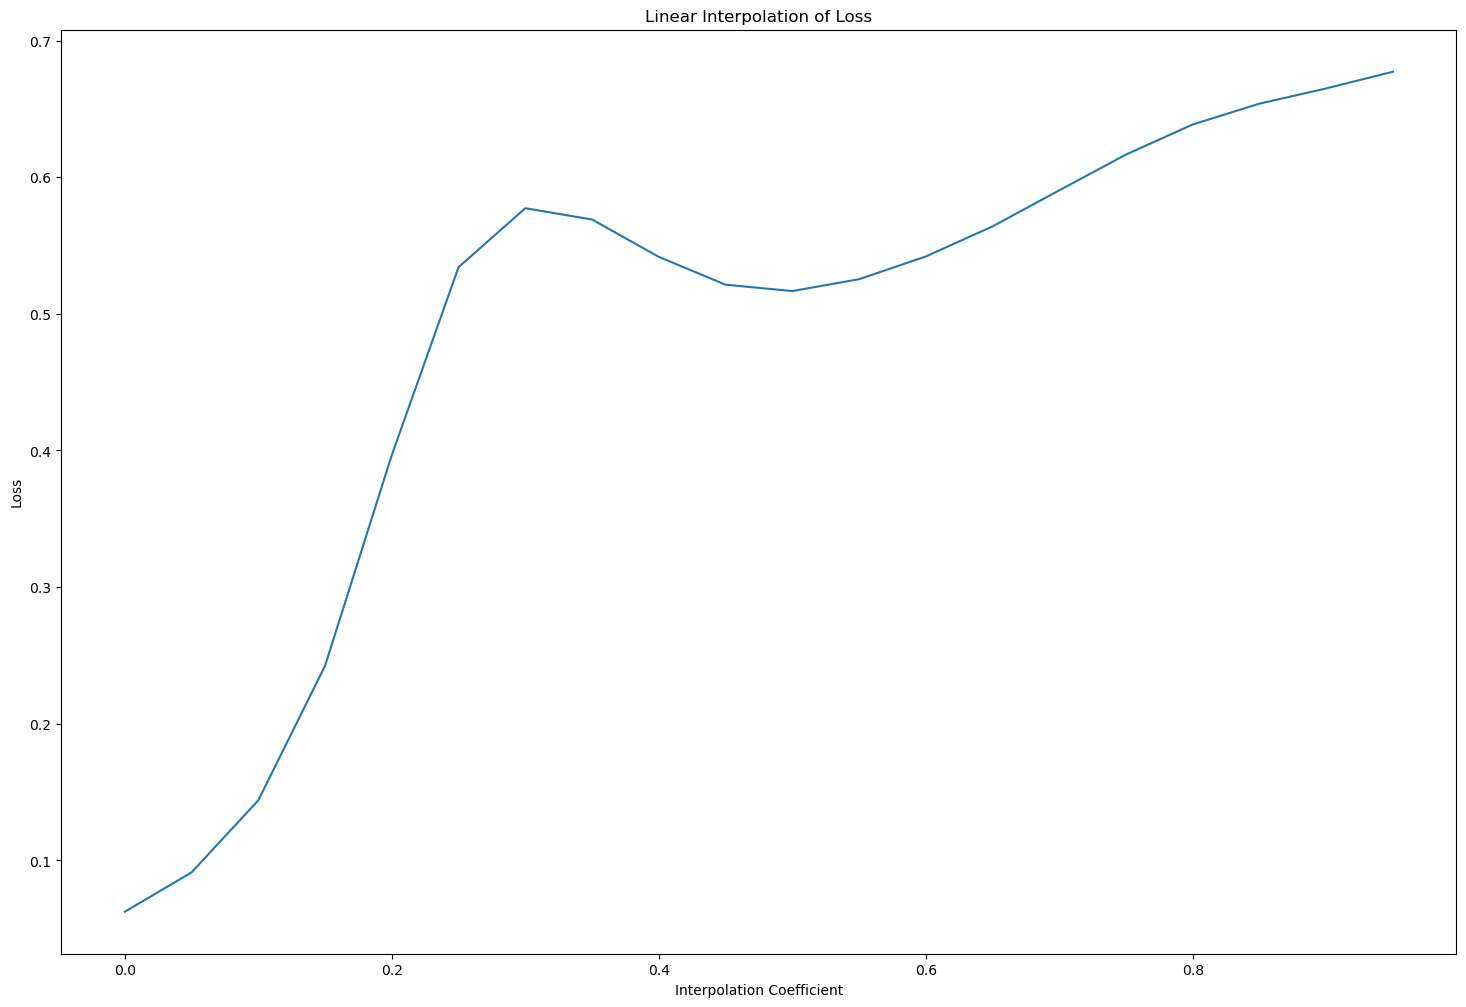

In [26]:
plt.plot([1/STEPS * i for i in range(STEPS)], loss_data)
plt.title('Linear Interpolation of Loss')
plt.xlabel('Interpolation Coefficient')
plt.ylabel('Loss')
axes = plt.gca()
# axes.set_ylim([2.300,2.325])
plt.show()

## 4. Planar Approximations of Loss Around a Point

Another core use for the library is producing 2-dimensional approximations of the loss-landscape topology around a point in parameter space. This is accomplished by sampling two random direction vectors in parameter space, and computing the loss at a number of points on the plane defined by the two vectors:

In [30]:
# compute loss data
pll = loss_landscapes.PlanarLossLandscape(model_final, STEPS, deepcopy_model=True)
pll.random_plane(distance=1, normalization='filter', random='normal')
# Uncomment the following line if you draw 2D random planar, you can replace model_initial woth model_one, model_two respectively
# pll.interpolation(model_initial, model_initial)
pll.stats_initializer()

In [31]:
# single batch computation
pll.warm_up(metric)
loss_data_fin = pll.compute(metric)

In [ ]:
eval_warm_up(pll, dataloader, device, criterion)

In [ ]:
loss_data_fin = eval_loss(pll, dataloader, device, criterion)

The loss values on this plane can be visualized in an intuitive and interpretable manner using contour plots or 3D surface plots:

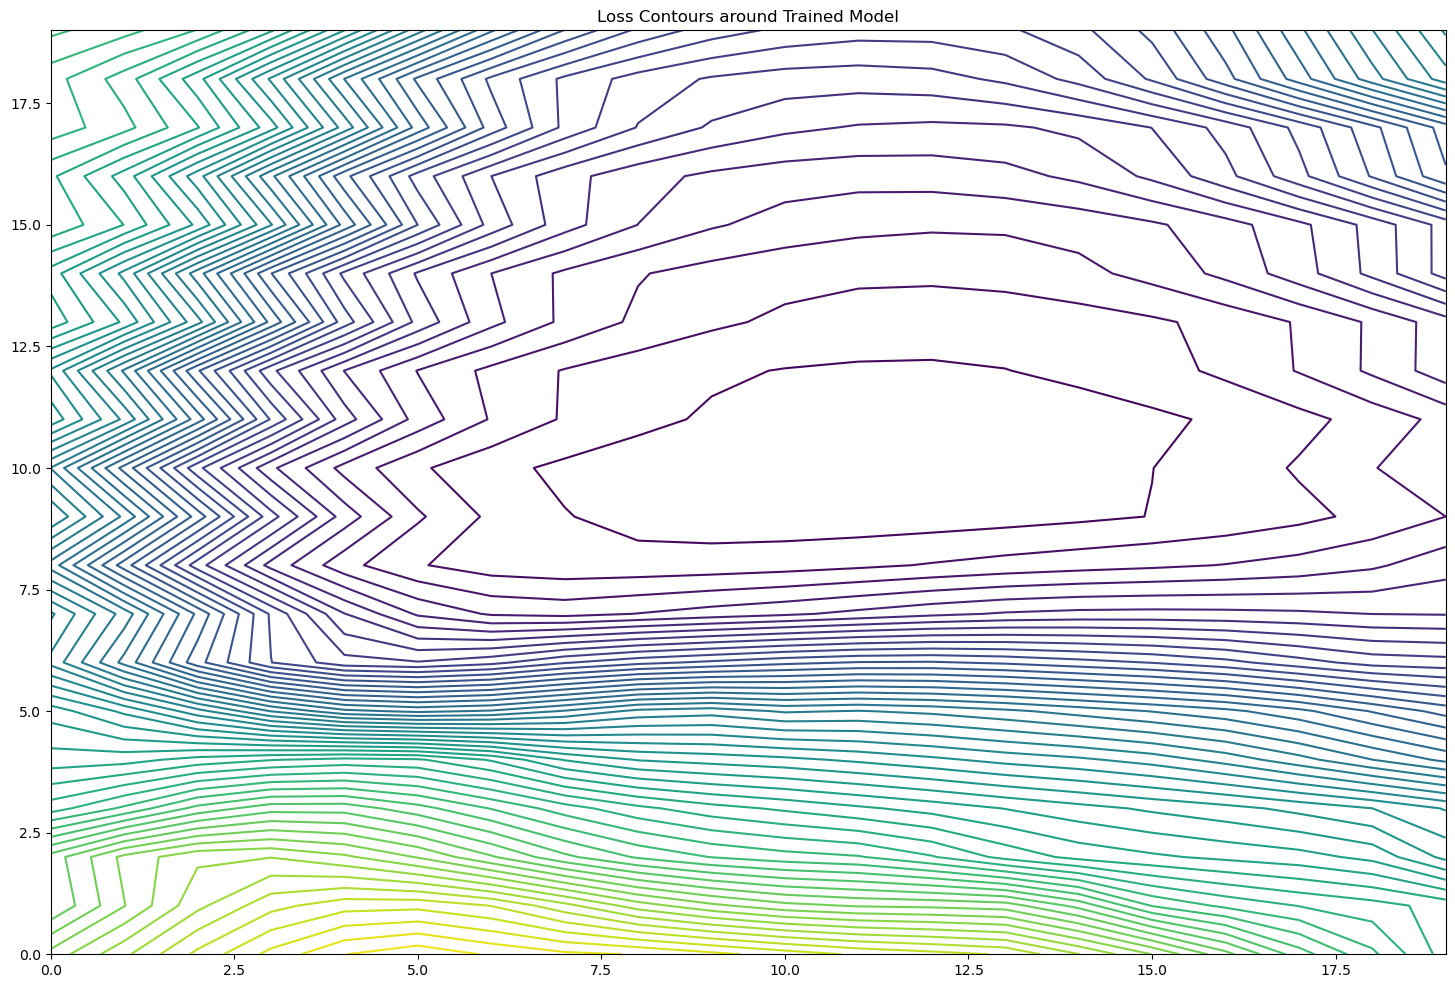

In [32]:
plt.contour(np.log(1.+loss_data_fin), levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

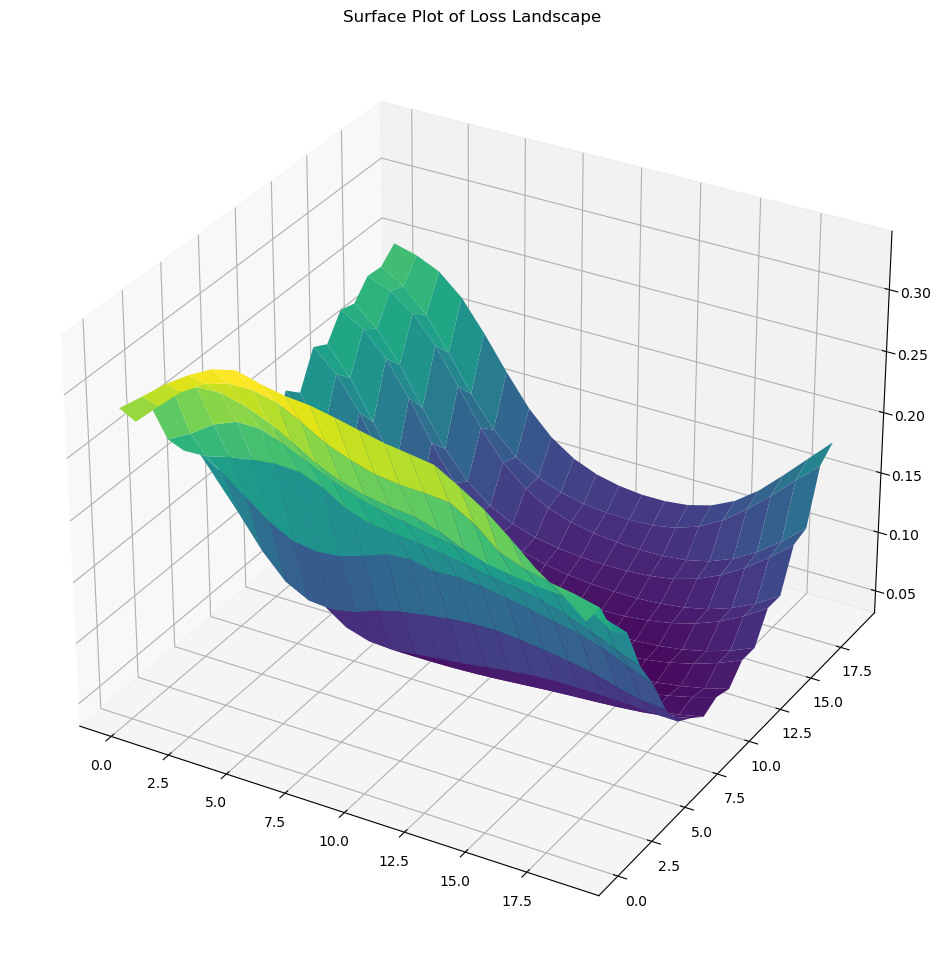

In [33]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, np.log(1.+loss_data_fin), rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

In [24]:
class DiceLoss(nn.Module):
    def __init__(self, softmax=False):
        super(DiceLoss, self).__init__()
        self.softmax = softmax
        self.smooth = 1e-7

    def forward(self, pred, target):
        if self.softmax:
            pred = F.softmax(pred,1)
        pred_flat = pred.contiguous().view(-1)
        true_flat = target.contiguous().view(-1)
        intersection = (pred_flat * true_flat).sum()
        union = torch.sum(pred_flat) + torch.sum(true_flat)
        
        return 1 - ((2. * intersection + self.smooth) / (union + self.smooth) )